In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets, models
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision

import copy
import time

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

    100% |████████████████████████████████| 512.6MB 56.4MB/s 
    100% |████████████████████████████████| 2.0MB 11.3MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, resample=False, expand=False, center=None),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
BatchSize=32

In [5]:
alexnet = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:04<00:00, 51052611.54it/s]


In [6]:
for parameter in alexnet.parameters():
    print(parameter.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [0]:
train_dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/My Drive/damage_dataset_redefined/train ',
        transform=data_transforms['train']
    )
trainLoader = torch.utils.data.DataLoader(train_dataset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

test_dataset = torchvision.datasets.ImageFolder(
        root='/content/drive/My Drive/damage_dataset_redefined/valid',
        transform=data_transforms['val']
    )
testLoader = torch.utils.data.DataLoader(test_dataset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader
                                         

In [8]:
# Size of train and test datasets
trainSetSize = len(trainLoader.dataset)
testSetSize = len(testLoader.dataset)
print('No. of samples in train set: '+str(trainSetSize))
print('No. of samples in test set: '+str(testSetSize))

No. of samples in train set: 1270
No. of samples in test set: 255


In [9]:
new_classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
new_classifier.add_module('fc',nn.Linear(4096,8))
new_classifier.add_module('softmax',nn.LogSoftmax())
alexnet.classifier = new_classifier
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [10]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')   
    net = alexnet.cuda()

GPU is available!


In [0]:
criterion = nn.NLLLoss() # Negative Log-likelihood
optimizer = optim.SGD(alexnet.parameters(), lr=1e-4, momentum=0.9) 

In [12]:
!pip install Pillow==4.1.1
!pip install PIL
!pip install image

    100% |████████████████████████████████| 5.7MB 7.1MB/s 
fastai 1.0.42 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


At Iteration: 1 /200  ;  Training Loss: 0.010386 ; Testing Acc: 89.020 ; Time consumed: 0m 26s 
At Iteration: 2 /200  ;  Training Loss: 0.008369 ; Testing Acc: 89.412 ; Time consumed: 0m 26s 
At Iteration: 3 /200  ;  Training Loss: 0.009523 ; Testing Acc: 88.235 ; Time consumed: 0m 26s 
At Iteration: 4 /200  ;  Training Loss: 0.008992 ; Testing Acc: 88.235 ; Time consumed: 0m 26s 
At Iteration: 5 /200  ;  Training Loss: 0.008242 ; Testing Acc: 90.196 ; Time consumed: 0m 26s 
At Iteration: 6 /200  ;  Training Loss: 0.008742 ; Testing Acc: 88.627 ; Time consumed: 0m 26s 
At Iteration: 7 /200  ;  Training Loss: 0.009125 ; Testing Acc: 88.627 ; Time consumed: 0m 26s 
At Iteration: 8 /200  ;  Training Loss: 0.008705 ; Testing Acc: 87.843 ; Time consumed: 0m 26s 
At Iteration: 9 /200  ;  Training Loss: 0.008633 ; Testing Acc: 87.843 ; Time consumed: 0m 26s 
At Iteration: 10 /200  ;  Training Loss: 0.008842 ; Testing Acc: 88.627 ; Time consumed: 0m 26s 
At Iteration: 11 /200  ;  Training Loss

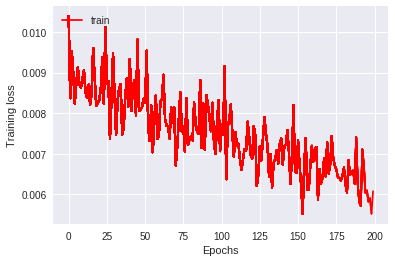

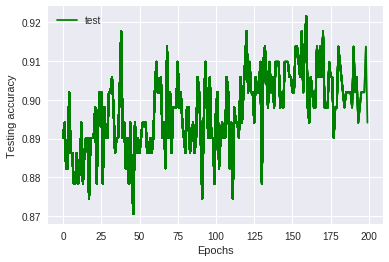

In [16]:
iterations = 200
trainLoss = []
testAcc = []
start = time.time()
for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0    
    alexnet.train(True) # For training
    count=0
    for data in trainLoader:
        inputs,labels = data
        # Wrap them in Variable
        count+=1
        #print(count)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)         
        # Initialize gradients to zero
        optimizer.zero_grad()
        # Feed-forward input data through the network        
        outputs = alexnet(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels)
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data.item()
    avgTrainLoss = runningLoss/1270.0
    trainLoss.append(avgTrainLoss)
    
    # Evaluating performance on test set for each epoch
    alexnet.train(False) # For testing
    running_correct = 0
    for data in testLoader:
        inputs,labels = data
        # Wrap them in Variable
        if use_gpu:
            inputs = Variable(inputs.cuda())
            outputs = alexnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu()
        else:
            inputs = Variable(inputs)
            outputs = alexnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum()
    avgTestAcc = float(running_correct)/255.0
    testAcc.append(avgTestAcc)
        
    # Plotting training loss vs Epochs
    fig1 = plt.figure(1)        
    plt.plot(range(epoch+1),trainLoss,'r-',label='train')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Training loss')   
    # Plotting testing accuracy vs Epochs
    fig2 = plt.figure(2)        
    plt.plot(range(epoch+1),testAcc,'g-',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Testing accuracy')    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f} ; Testing Acc: {:.3f} ; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,avgTestAcc*100,epochEnd//60,epochEnd%60))
end = time.time()-start 
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [0]:
torch.save(alexnet.state_dict(),'/content/drive/My Drive/ale.ckpt')